<a href="https://colab.research.google.com/github/angelrodriguez0617/CS-4710-Machine-Learning-II/blob/main/A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CS 4710 - Machine Learning II

## Assigment A8

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A sinusoidal-forecasting example



Generate own timeseries in the form of y(t) = A(t) * cos(wt) + noise

In [22]:
import numpy as np
import os

# Parameters for the time series
A = 1       # Amplitude, can be made a function of t for varying amplitude
w = 2*np.pi # Angular frequency, 2*pi for a 1-second period
cycles = 5
end_time = cycles * w
t = np.linspace(0, end_time, 10000) # Time vector from 0 to 10 seconds

# Generate the time series
y = A * np.cos(w * t) + np.random.normal(0, 0.5, len(t))

# Assign the generated time series to 'temperature'
temperature = y

# Create 'raw_data' with the same time series repeated for each 'feature'
# Assuming you want to simulate multiple features as in the original dataset
num_features = 1  # This is an example, set it to the number of features you need
raw_data = np.tile(temperature, (num_features, 1)).T

# Now you can continue with the rest of your code using 'temperature' and 'raw_data'


**Plotting the timeseries**

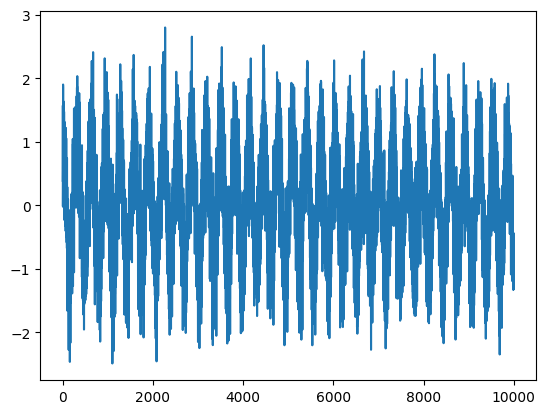

In [23]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 2000 points of the timeseries**

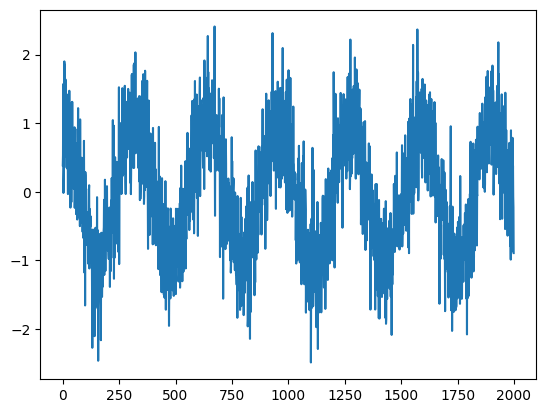

In [24]:
plt.plot(range(2000), temperature[:2000])

**Computing the number of samples we'll use for each data split**

In [25]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 5000
num_val_samples: 2500
num_test_samples: 2500


### Preparing the data

**Normalizing the data**

In [26]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [27]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [32]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [33]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 1)
targets shape: (256,)


## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
17/17 [==============================] - 10s 313ms/step - loss: 0.5809 - mae: 0.6198 - val_loss: 0.4120 - val_mae: 0.5248
Epoch 2/50
17/17 [==============================] - 6s 335ms/step - loss: 0.3697 - mae: 0.4845 - val_loss: 0.2872 - val_mae: 0.4312
Epoch 3/50
17/17 [==============================] - 5s 296ms/step - loss: 0.3200 - mae: 0.4517 - val_loss: 0.2849 - val_mae: 0.4292
Epoch 4/50
17/17 [==============================] - 5s 309ms/step - loss: 0.3118 - mae: 0.4418 - val_loss: 0.2812 - val_mae: 0.4251
Epoch 5/50
17/17 [==============================] - 6s 314ms/step - loss: 0.3067 - mae: 0.4420 - val_loss: 0.2872 - val_mae: 0.4307
Epoch 6/50
17/17 [==============================] - 5s 297ms/step - loss: 0.3004 - mae: 0.4359 - val_loss: 0.2799 - val_mae: 0.4237
Epoch 7/50
17/17 [==============================] - 6s 355ms/step - loss: 0.2960 - mae: 0.4324 - val_loss: 0.2796 - val_mae: 0.4235
Epoch 8/50
17/17 [==============================] - 6s 348ms/step - loss: 0

In [35]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
17/17 [==============================] - 15s 658ms/step - loss: 0.3736 - mae: 0.4849 - val_loss: 0.3070 - val_mae: 0.4437
Epoch 2/50
17/17 [==============================] - 10s 610ms/step - loss: 0.3248 - mae: 0.4531 - val_loss: 0.3085 - val_mae: 0.4473
Epoch 3/50
17/17 [==============================] - 11s 613ms/step - loss: 0.3129 - mae: 0.4474 - val_loss: 0.3022 - val_mae: 0.4408
Epoch 4/50
17/17 [==============================] - 10s 600ms/step - loss: 0.3177 - mae: 0.4467 - val_loss: 0.3023 - val_mae: 0.4410
Epoch 5/50
17/17 [==============================] - 10s 611ms/step - loss: 0.3120 - mae: 0.4436 - val_loss: 0.3020 - val_mae: 0.4412
Epoch 6/50
17/17 [==============================] - 14s 758ms/step - loss: 0.3052 - mae: 0.4397 - val_loss: 0.3039 - val_mae: 0.4433
Epoch 7/50
17/17 [==============================] - 13s 745ms/step - loss: 0.3110 - mae: 0.4437 - val_loss: 0.3014 - val_mae: 0.4406
Epoch 8/50
17/17 [==============================] - 10s 549ms/step - 

4/4 [==============================] - 2s 96ms/step - loss: 0.2661 - mae: 0.4118
Test MAE: 0.41


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset)

Epoch 1/50
17/17 [==============================] - 4s 81ms/step - loss: 0.6255 - mae: 0.6486 - val_loss: 0.4501 - val_mae: 0.5495
Epoch 2/50
17/17 [==============================] - 1s 34ms/step - loss: 0.3835 - mae: 0.4973 - val_loss: 0.3133 - val_mae: 0.4522
Epoch 3/50
17/17 [==============================] - 1s 41ms/step - loss: 0.2872 - mae: 0.4270 - val_loss: 0.2749 - val_mae: 0.4228
Epoch 4/50
17/17 [==============================] - 1s 34ms/step - loss: 0.2683 - mae: 0.4118 - val_loss: 0.2737 - val_mae: 0.4210
Epoch 5/50
17/17 [==============================] - 1s 40ms/step - loss: 0.2675 - mae: 0.4113 - val_loss: 0.2724 - val_mae: 0.4186
Epoch 6/50
17/17 [==============================] - 1s 37ms/step - loss: 0.2672 - mae: 0.4116 - val_loss: 0.2743 - val_mae: 0.4216
Epoch 7/50
17/17 [==============================] - 1s 37ms/step - loss: 0.2665 - mae: 0.4110 - val_loss: 0.2729 - val_mae: 0.4174
Epoch 8/50
17/17 [==============================] - 1s 52ms/step - loss: 0.2660 - m